In [9]:
from data import PokemonIMG
import matplotlib.pyplot as plt

In [10]:
dset = PokemonIMG()

In [11]:
dset[0]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9490, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9529, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9529, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9569, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

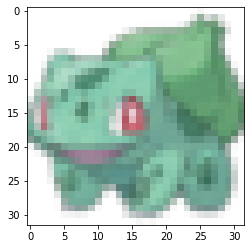

In [12]:
plt.imshow(dset[0][0].permute(1, 2, 0))

In [5]:
import torch
import math

In [6]:
num_samples = len(dset)
print(num_samples)
train_split = 0.7
val_split = 0.2
test_split = 0.1

num_train = math.floor(num_samples*train_split)
num_val = math.floor(num_samples*val_split)
num_test = math.floor(num_samples*test_split)
num_test = num_test + (num_samples - num_train - num_val - num_test)
print(num_train + num_val + num_test)

819
819


In [7]:
train_set, val_set, test_set = torch.utils.data.random_split(dset, [num_train, num_val, num_test])

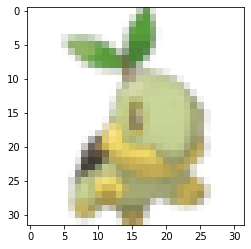

In [8]:
plt.imshow(train_set[0][0][:3,:,:].permute(1, 2, 0))

In [2]:
import tensorboard as tb

In [3]:
experiment_id = "ubGPkY00Rv6cRHbsQB5bvA"

In [15]:
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)

In [16]:
experiment

In [1]:
import os
import scipy.misc
import tensorflow as tf

def save_images_from_event(fn, tag, output_dir='./'):
    assert(os.path.isdir(output_dir))

    image_str = tf.placeholder(tf.string)
    im_tf = tf.image.decode_image(image_str)

    sess = tf.InteractiveSession()
    with sess.as_default():
        count = 0
        for e in tf.train.summary_iterator(fn):
            for v in e.summary.value:
                if v.tag == tag:
                    im = im_tf.eval({image_str: v.image.encoded_image_string})
                    output_fn = os.path.realpath('{}/image_{:05d}.png'.format(output_dir, count))
                    print("Saving '{}'".format(output_fn))
                    scipy.misc.imsave(output_fn, im)
                    count += 1  

In [5]:
sess = tf.compat.v1.InteractiveSession()

In [14]:
event_path = os.path.join(os.getcwd(), "TBtrain", "events.out.tfevents.1653405743.LAPTOP-JG0TF9EA.23876.0")

In [17]:
with sess.as_default():
    count = 0
    for e in tf.compat.v1.train.summary_iterator(event_path):
        print(e)
        print(e.summary.value)

wall_time: 1653404423.7508016
file_version: "brain.Event:2"

[]


In [2]:
import torch as t
import math
from torch import nn
from torch.nn import DataParallel
from torchvision import transforms, datasets

from dml import DiscretizedMixtureLogitsDistribution
from residual import Residual
from vnca import VNCA
from train import train
from data import PokemonIMG
from loss import elbo

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
z_size = 256
nca_hid = 128
n_mixtures = 1
batch_size = 32
dmg_size = 16
p_update = 1.0
min_steps, max_steps = 64, 128

filter_size = 5
pad = filter_size // 2
encoder_hid = 32
h = w = 32
n_channels = 3


def state_to_dist(state):
    return DiscretizedMixtureLogitsDistribution(n_mixtures, state[:, :n_mixtures * 10, :, :])


encoder = nn.Sequential(
    nn.Conv2d(n_channels, encoder_hid * 2 ** 0, filter_size, padding=pad), nn.ELU(),  # (bs, 32, h, w)
    nn.Conv2d(encoder_hid * 2 ** 0, encoder_hid * 2 ** 1, filter_size, padding=pad, stride=2), nn.ELU(),  # (bs, 64, h//2, w//2)
    nn.Conv2d(encoder_hid * 2 ** 1, encoder_hid * 2 ** 2, filter_size, padding=pad, stride=2), nn.ELU(),  # (bs, 128, h//4, w//4)
    nn.Conv2d(encoder_hid * 2 ** 2, encoder_hid * 2 ** 3, filter_size, padding=pad, stride=2), nn.ELU(),  # (bs, 256, h//8, w//8)
    nn.Conv2d(encoder_hid * 2 ** 3, encoder_hid * 2 ** 4, filter_size, padding=pad, stride=2), nn.ELU(),  # (bs, 512, h//16, w//16),
    nn.Flatten(),  # (bs, 512*h//16*w//16)
    nn.Linear(encoder_hid * (2 ** 4) * h // 16 * w // 16, 2 * z_size),
)

update_net = nn.Sequential(
    nn.Conv2d(z_size, nca_hid, 3, padding=1),
    Residual(
        nn.Conv2d(nca_hid, nca_hid, 1),
        nn.ELU(),
        nn.Conv2d(nca_hid, nca_hid, 1),
    ),
    Residual(
        nn.Conv2d(nca_hid, nca_hid, 1),
        nn.ELU(),
        nn.Conv2d(nca_hid, nca_hid, 1),
    ),
    Residual(
        nn.Conv2d(nca_hid, nca_hid, 1),
        nn.ELU(),
        nn.Conv2d(nca_hid, nca_hid, 1),
    ),
    Residual(
        nn.Conv2d(nca_hid, nca_hid, 1),
        nn.ELU(),
        nn.Conv2d(nca_hid, nca_hid, 1),
    ),
    nn.Conv2d(nca_hid, z_size, 1)
)
update_net[-1].weight.data.fill_(0.0)
update_net[-1].bias.data.fill_(0.0)

# encoder = DataParallel(encoder)
# update_net = DataParallel(update_net)

dset = PokemonIMG()

num_samples = len(dset)
train_split = 0.7
val_split = 0.2
test_split = 0.1

num_train = math.floor(num_samples*train_split)
num_val = math.floor(num_samples*val_split)
num_test = math.floor(num_samples*test_split)
num_test = num_test + (num_samples - num_train - num_val - num_test)

train_set, val_set, test_set = t.utils.data.random_split(dset, [num_train, num_val, num_test])

vnca = VNCA(h, w, n_channels, z_size, encoder, update_net, train_set, val_set, test_set, state_to_dist, batch_size, dmg_size, p_update, min_steps, max_steps)


VNCA(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ELU(alpha=1.0)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): ELU(alpha=1.0)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2048, out_features=512, bias=True)
  )
  (nca): NCA(
    (update_net): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Residual(
        (delegate): Sequential(
          (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): ELU(alpha=1.0)
          (2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
 

In [3]:
x, y = next(vnca.train_loader)
vnca.forward(x, 1, elbo)

shape of z torch.Size([32, 1, 256])
reshape 1: torch.Size([32, 256])
reshape 2: torch.Size([32, 256, 1])
reshape 3: torch.Size([32, 256, 1, 1])
reshape 4: torch.Size([32, 256, 32, 32])
shape of the state to propagate torch.Size([32, 256, 32, 32])
logits shapetorch.Size([32, 10, 32, 32])


c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [4]:
vnca.eval_batch()

shape of z torch.Size([32, 1, 256])
reshape 1: torch.Size([32, 256])
reshape 2: torch.Size([32, 256, 1])
reshape 3: torch.Size([32, 256, 1, 1])
reshape 4: torch.Size([32, 256, 32, 32])


c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


shape of the state to propagate torch.Size([32, 256, 32, 32])
logits shapetorch.Size([32, 10, 32, 32])


c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


logits shapetorch.Size([8, 10, 32, 32])
l prev tensor([[[ 0.2400,  0.2400,  0.2400,  ...,  0.2400,  0.2400,  0.2400],
         [ 0.2400,  0.2400,  0.2400,  ...,  0.2400,  0.2400,  0.2400],
         [ 0.2400,  0.2400,  0.2400,  ...,  0.2400,  0.2400,  0.2400],
         ...,
         [ 0.2400,  0.2400,  0.2400,  ...,  0.2400,  0.2400,  0.2400],
         [ 0.2400,  0.2400,  0.2400,  ...,  0.2400,  0.2400,  0.2400],
         [ 0.2400,  0.2400,  0.2400,  ...,  0.2400,  0.2400,  0.2400]],

        [[-1.8504, -1.8504, -1.8504,  ..., -1.8504, -1.8504, -1.8504],
         [-1.8504, -1.8504, -1.8504,  ..., -1.8504, -1.8504, -1.8504],
         [-1.8504, -1.8504, -1.8504,  ..., -1.8504, -1.8504, -1.8504],
         ...,
         [-1.8504, -1.8504, -1.8504,  ..., -1.8504, -1.8504, -1.8504],
         [-1.8504, -1.8504, -1.8504,  ..., -1.8504, -1.8504, -1.8504],
         [-1.8504, -1.8504, -1.8504,  ..., -1.8504, -1.8504, -1.8504]],

        [[-0.0302, -0.0302, -0.0302,  ..., -0.0302, -0.0302, -0.0302]